In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import mnist
import numpy as np
np.random.seed(67)

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tnrange, tqdm_notebook

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.0)

In [59]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_d(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(x)

def relu(x):
    return np.where(x > 0, x, 0)

def relu_d(x):
    return np.where(x > 0, 1, 0)

def he_init(fan_in, gain=1.0):
    return np.sqrt(gain / fan_in)

def l1(W):
    return np.sum(np.abs(W))

def l2(W):
    return np.sum(np.square(W))

def cross_entropy(y_preds, y_labels):
    return np.mean(-np.sum(y_labels * np.log(y_preds + 1e-7), axis=1))

def one_hot(indices, num_labels):
    return np.eye(num_labels)[indices]

def label_accuracy(y_probs, y_labels):
    y_ = np.argmax(y_probs, axis=1)
    y = np.argmax(y_labels, axis=1)
    accuracy = np.mean(np.equal(y_, y))
    return accuracy

In [90]:
train_images = mnist.read_images('train-images-idx3-ubyte')
train_labels = mnist.read_labels('train-labels-idx1-ubyte')
test_images = mnist.read_images('t10k-images-idx3-ubyte')
test_labels = mnist.read_labels('t10k-labels-idx1-ubyte')

train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

train_labels = one_hot(train_labels, 10)
test_labels = one_hot(test_labels, 10)

In [101]:
# constants
num_epochs = 10
batch_size = 32
learning_rate = 1e-4
regularization_strength = 1e-2

# parameters
W0 = np.random.normal(scale=1e-3, size=(784, 300))
W1 = np.random.normal(scale=1e-3, size=(300, 10))
b0 = np.zeros(shape=(300,))
b1 = np.zeros(shape=(10,))

num_train = len(train_labels)
num_test = len(test_labels)

num_batches = num_train // batch_size

with tnrange(num_epochs) as pbar_epoch:
    epoch_losses = []
    epoch_accuracies = []
    for epoch in pbar_epoch:
        batch_loss = 0
        batch_accuracy = 0
        with tnrange(num_batches, leave=False) as pbar_batch:
            for batch_index in pbar_batch:
                batch_start = batch_index * batch_size
                batch_end = batch_start + batch_size

                X = train_images[batch_start:batch_end]
                y = train_labels[batch_start:batch_end]

                # forward prop
                h0_logits = np.dot(X, W0) + b0
                h0 = relu(h0_logits)
                h1_logits = np.dot(h0, W1) + b1
                h1 = softmax(h1_logits)
                
                # backprop
                delta1 = h1 - y
                dW1 = np.dot(h0.T, delta1)
                db1 = np.sum(delta1, axis=0)

                delta0 = delta1.dot(W1.T) * relu_d(h0)
                dW0 = np.dot(X.T, delta0)
                db0 = np.sum(delta0, axis=0)

                dW1 += (regularization_strength / batch_size) * W1
                dW0 += (regularization_strength / batch_size) * W0

                # gradient descent
                W0 += -learning_rate * dW0
                b0 += -learning_rate * db0

                W1 += -learning_rate * dW1
                b1 += -learning_rate * db1

                # loss
                loss = cross_entropy(h1, y)
                loss += (regularization_strength / (batch_size * 2)) * np.sum([l2(W0), l2(W1)])                
                accuracy = label_accuracy(h1, y)

                batch_loss += loss
                batch_accuracy += accuracy

                loss_mean = batch_loss / (batch_index + 1)
                accuracy_mean = batch_accuracy / (batch_index + 1)
                pbar_batch.set_description('loss: {:.8f}, accuracy: {:.2f}'.format(loss_mean, accuracy_mean))

        epoch_losses.append(loss_mean)
        epoch_accuracies.append(accuracy_mean)
        pbar_epoch.set_description('loss: {:.8f}, accuracy: {:.2f}'.format(loss_mean, accuracy_mean))

In [102]:
X = test_images
y = test_labels

h0_logits = np.dot(X, W0) + b0
h0 = relu(h0_logits)
h1_logits = np.dot(h0, W1) + b1
h1 = softmax(h1_logits)

loss = cross_entropy(h1, y)
accuracy = label_accuracy(h1, y)
print('loss: {:.8f}, accuracy: {:.2f}'.format(loss, accuracy))

loss: 0.18372094, accuracy: 0.97


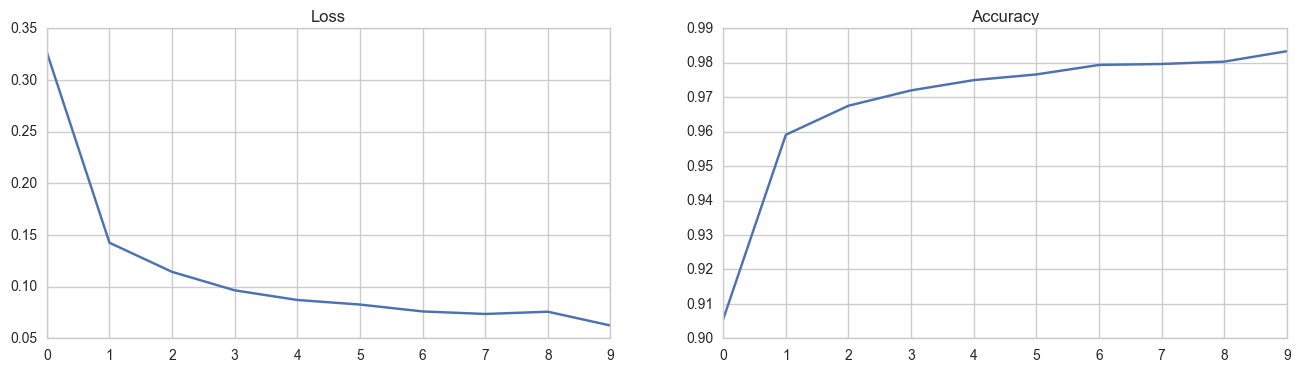

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(epoch_losses)
ax2.plot(epoch_accuracies)
ax1.set_title('Loss')
ax2.set_title('Accuracy')